# Face Recognition using VGG16 and SIFT descriptors
based on paper: Face Recognition Using the SR-CNN Model

# Import libraries

In [1]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Activation, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, regularizers, utils
from tensorflow.keras import applications
from tensorflow.keras.losses import categorical_crossentropy,categorical_hinge,hinge,squared_hinge
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization , Input ,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import  EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split

import cv2

import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from datetime import datetime
import io
import itertools
from packaging import version



from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

import sklearn.metrics
from tensorflow.keras.optimizers import SGD


np.random.seed(1000)
# Load the TensorBoard notebook extension
%load_ext tensorboard


In [ ]:
def normalize_mean_var(arr):
    arr -= np.mean(arr)
    arr /= np.var(arr)
    return arr

# Prepare data

In [2]:
ritf_hist_train_path = "npy_saves/RITF_hist_reduced_128_train_imc_50.npy"
ritf_hist_valid_path = "npy_saves/RITF_hist_reduced_128_valid_imc_50.npy"

X_traing_hists_reduced = np.load(ritf_hist_train_path)
X_valid_hists_reduced = np.load(ritf_hist_valid_path)

In [3]:
ritf_feature_selection_path = "npy_saves/RITF_feature_selection_128_valid_imc_50.npy"
feature_sel = np.load(ritf_feature_selection_path)

In [4]:
train_path = "npy_saves/Train_imc_50.npy"
valid_path = "npy_saves/valid_imc_50.npy"

traing_data = np.load(train_path, allow_pickle=True)
valid_data = np.load(valid_path, allow_pickle=True)

In [5]:
y_train_path = "npy_saves/y_train_imc_50.npy"
y_valid_path = "npy_saves/y_valid_imc_50.npy"

y_training = np.load(y_train_path)
y_validation = np.load(y_valid_path)

# OpenCV face detection

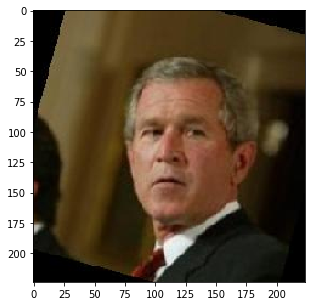

In [6]:
selected_image = traing_data[0][0][0]
fig=plt.figure(figsize=(5, 5))
fig.add_subplot(1, 1, 1)
plt.imshow(selected_image)
plt.show()

In [7]:
haar_cascade_face = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')


In [8]:
def get_face(image_gray):
    
    faces_rects = haar_cascade_face.detectMultiScale(image_gray, scaleFactor = 1.2, minNeighbors = 5);
    if len(faces_rects) >= 1:
        (x,y,w,h) = faces_rects[0]
        cropped_face = image_gray[y:y+h, x:x+w]
        return cropped_face
    return image_gray

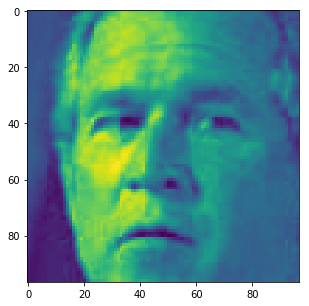

In [9]:
fig=plt.figure(figsize=(5, 5))
fig.add_subplot(1, 1, 1)
img = cv2.normalize(selected_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
# load the image, convert it to grayscale, and describe it
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_face = get_face(img)
plt.imshow(img_face)
plt.show()

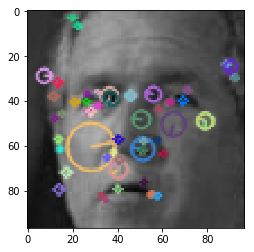

57

In [10]:
sift = cv2.xfeatures2d.SIFT_create()

kp, des = sift.detectAndCompute(img_face, None)
img_with_sift = cv2.drawKeypoints(img_face,kp,img_face,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_with_sift)
plt.show()
len(kp)


# Extract Histograms

In [11]:
import math


def extract_sift(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    
    # load the image, convert it to grayscale, and describe it
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_cropped_face = get_face(gray)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(gray_cropped_face, None)
    if len(kp) == 0:
        print("error ", len(kp))
        kp, des = sift.detectAndCompute(gray, None)

    Xtrain = []
   

    for i, d in enumerate(des):
        if len(d) == 128:
            Xtrain.append(d)
        
    Xtrain = np.array(Xtrain)
    
    
    
    return Xtrain


In [12]:
def label_converter(arr):
    for i in range(len(arr)):
        if arr[i] == 1:
            return i
    return -1

In [13]:
from IPython.display import clear_output

def preprocess(gen):
    res = []
    for i in range(len(gen)):
        clear_output(wait=True)
        print("{}/{}".format(i, len(gen)))
        x, y = gen[i]
        sift = np.asarray([extract_sift(img) for img in x])
        lbls = np.asarray([label_converter(l) for l in y])
        res.append([sift, lbls])

    return np.asarray(res)

traing_data_sift_hists = preprocess(traing_data)
valid_data_sift_hists = preprocess(valid_data)


15/16


In [14]:
def remove_batches(arr):
    X = []
    y = []
    for j in range(len(arr)):
        batch = arr[j]
        for i in range(len(batch[0])):
            X.append(batch[0][i])
            y.append(batch[1][i])
        
    return np.asarray(X), np.asarray(y)

traing_data_sift_hists, y_traing_data = remove_batches(traing_data_sift_hists)
valid_data_sift_hists, y_valid_data = remove_batches(valid_data_sift_hists)

In [ ]:
traing_data_sift_hists.shape

In [15]:
def get_seperate(data, labels):
    x = []
    y = []
    for i, a in enumerate(data):
        for b in a:
            x.append(b)
            y.append(labels[i])
            
    return np.asarray(x), np.asarray(y)

x_traing_sift, y_traing_sift = get_seperate(traing_data_sift_hists, y_traing_data)
x_valid_sift, y_valid_sift = get_seperate(valid_data_sift_hists, y_valid_data)

In [ ]:
y_valid_sift.shape

In [ ]:
x_traing_sift.shape

# Training

In [26]:
from sklearn.cluster import MiniBatchKMeans
K = 1024*4
K_model = MiniBatchKMeans(n_clusters=K,max_iter=300,batch_size=K*2,max_no_improvement=30,init_size=3*K).fit(x_traing_sift)

In [27]:
len(K_model.cluster_centers_)

4096

In [30]:
def get_sift_histogram(img):
    sift = extract_sift(img)
    pred = K_model.predict(sift)
    hist = np.bincount(pred, minlength=K)
    return hist


In [29]:
from IPython.display import clear_output

def extract_sift_histogram(gen):
    res = []
    for i in range(len(gen)):
        clear_output(wait=True)
        print("{}/{}".format(i, len(gen)))
        x, y = gen[i]
        for j, a in enumerate(x):
            
            SIFT = extract_sift(a)
            if len(SIFT) != 0:
                pred = K_model.predict(SIFT)
                hist = np.bincount(pred, minlength=K)
                res.append(hist)
    return np.asarray(res)

traing_data_sift_hist = extract_sift_histogram(traing_data)
valid_data_sift_hist = extract_sift_histogram(valid_data)

15/16


In [36]:
np.save('npy_saves/sift_hist_50m_4k_training', traing_data_sift_hist)
np.save('npy_saves/sift_hist_50m_4k_validation', valid_data_sift_hist)

In [ ]:
for a in traing_data_sift_hist:
    print(a[:1])

In [31]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix(model, X_test, y_test, title):
    disp = plot_confusion_matrix(model, X_test, y_test,
                                cmap=plt.cm.Blues,
                                normalize='true')
    disp.ax_.set_title('Confusion matrix: ' + title)

In [32]:
def Linear_SVM_classification(X_train, X_test, y_train, y_test):
    #LinearSVC
    from sklearn.svm import LinearSVC

    svc= LinearSVC(C=100.0, random_state=42, max_iter=1000, verbose=1)
    svc.fit(X_train, y_train)

    svcpred = svc.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, svcpred)
    SVC_acc = metrics.accuracy_score(y_test, svcpred)

    print('Linear SVC accuracy: {}'.format(SVC_acc))
        
Linear_SVM_classification(traing_data_sift_hist, valid_data_sift_hist, y_training, y_validation)

[LibLinear]Linear SVC accuracy: 0.6688311688311688


Random Forest Accuracy: 0.5876623376623377


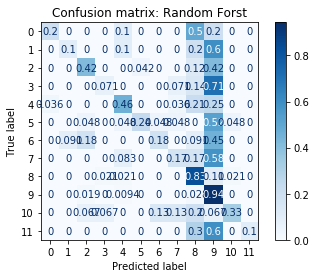

In [33]:
def RF_classification(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators = 100)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, pred)
    RF_acc = metrics.accuracy_score(y_test, pred)

    print("Random Forest Accuracy:", RF_acc)
    confusion_matrix(clf, X_test, y_test, "Random Forst")
    
RF_classification(traing_data_sift_hist, valid_data_sift_hist, y_training, y_validation)

SVC (kernel = linear):  0.6363636363636364
SVC (kernel = poly):  0.34415584415584416
SVC (kernel = rbf):  0.461038961038961
SVC (kernel = sigmoid):  0.5844155844155844


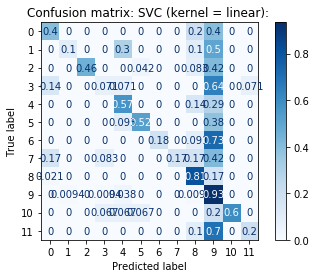

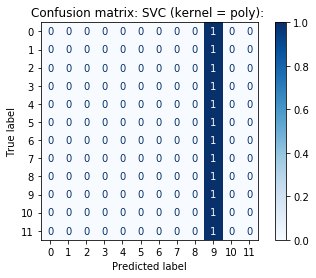

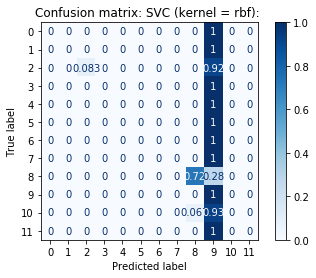

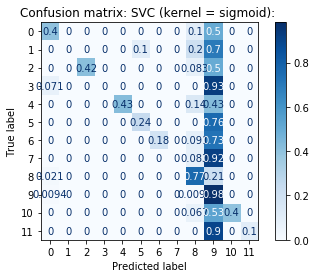

In [34]:
def SVM_classification(X_train, X_test, y_train, y_test):
    #SVM
    from sklearn.svm import SVC

    for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
        svc= SVC(kernel = kernel)

        svc.fit(X_train, y_train)
        svcpred = svc.predict(X_test)
        cnf_matrix = metrics.confusion_matrix(y_test, svcpred)
        SVC_acc = metrics.accuracy_score(y_test, svcpred)

        print('SVC (kernel = {}): '.format(kernel),SVC_acc)
        title = 'SVC (kernel = {}): '.format(kernel)
        confusion_matrix(svc, X_test, y_test, title)
        
SVM_classification(traing_data_sift_hist, valid_data_sift_hist, y_training, y_validation)